In this Colab, we explore some of the fundamental features of TensorFlow Probability. This is adpated from the TFP examples page

https://github.com/tensorflow/probability/

### Dependencies & Prerequisites


In [0]:
#@title Install { display-mode: "form" }
TF_Installation = 'TF2 Stable (GPU)' #@param ['TF2 Nightly (GPU)', 'TF2 Stable (GPU)','System']

if TF_Installation == 'TF2 Nightly (GPU)':
  !pip install -q --upgrade tf-nightly-gpu
  print('Installation of `tf-nightly-gpu` complete.')
elif TF_Installation == 'TF2 Stable (GPU)':
  !pip install -q --upgrade tensorflow-gpu==2.3
  print('Installation of `tensorflow-gpu==2.3` complete.')
elif TF_Installation == 'System':
  pass
else:
  raise ValueError('Selection Error: Please select a valid '
                   'installation option.')

     |████████████████████████████████| 201.6MB 127kB/s 
     |████████████████████████████████| 4.3MB 34.0MB/s 
     |████████████████████████████████| 61kB 20.6MB/s 
     |████████████████████████████████| 450kB 39.9MB/s 
Installation of `tf-nightly-gpu-2.0-preview` complete.


In [0]:
#@title Install { display-mode: "form" }
TFP_Installation = "Stable" #@param ["Nightly", "Stable", "System"]

if TFP_Installation == "Nightly":
  !pip install -q tfp-nightly
  print("Installation of `tfp-nightly` complete.")
elif TFP_Installation == "Stable":
  !pip install -q --upgrade tensorflow-probability
  print("Installation of `tensorflow-probability` complete.")
elif TFP_Installation == "System":
  pass
else:
  raise ValueError("Selection Error: Please select a valid "
                   "installation option.")


!pip install -q --upgrade seaborn

     |████████████████████████████████| 1.1MB 2.8MB/s 
Installation of `tfp-nightly` complete.


In [0]:
#@title Import { display-mode: "form" }

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()

import tensorflow_probability as tfp

sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)
plt.rcParams['image.cmap'] = 'viridis'

%matplotlib inline

tfd = tfp.distributions

In [0]:
#@title Utils { display-mode: "form" }
def print_subclasses_from_module(module, base_class, maxwidth=80):
  import functools, inspect, sys
  subclasses = [name for name, obj in inspect.getmembers(module)
                if inspect.isclass(obj) and issubclass(obj, base_class)]
  def red(acc, x):
    if not acc or len(acc[-1]) + len(x) + 2 > maxwidth:
      acc.append(x)
    else:
      acc[-1] += ", " + x
    return acc
  print('\n'.join(functools.reduce(red, subclasses, [])))

In [0]:
# Code can run seamlessly on a GPU, just change Colab runtime type
# in the 'Runtime' menu.
print(tf.config.list_physical_devices())
if len(tf.config.list_physical_devices('GPU')) > 0:
  print("Using GPU device",tf.test.gpu_device_name())
else:
  print("Using a CPU")

Using a CPU


## TensorFlow Probability

*TensorFlow Probability is a library for probabilistic reasoning and statistical analysis in TensorFlow.*

At the lowest level it allows us to create and sample from different probability distributions.

At a higher level we can construct probabilistic layers in our network and use different optimizers, MCMC and Variational Inference techniques.



## Distributions
A `tfp.distributions.Distribution` is a class with two core methods: `sample` and `log_prob`.

TFP has a lot of distributions!


In [0]:
print_subclasses_from_module(tfp.distributions, tfp.distributions.Distribution)

Autoregressive, BatchReshape, Bernoulli, Beta, Binomial, Blockwise, Categorical
Cauchy, Chi, Chi2, Deterministic, Dirichlet, DirichletMultinomial, Distribution
Empirical, ExpRelaxedOneHotCategorical, Exponential, FiniteDiscrete, Gamma
GammaGamma, GaussianProcess, GaussianProcessRegressionModel, GeneralizedPareto
Geometric, Gumbel, HalfCauchy, HalfNormal, HiddenMarkovModel, Horseshoe
Independent, InverseGamma, InverseGaussian, JointDistribution
JointDistributionCoroutine, JointDistributionNamed, JointDistributionSequential
Kumaraswamy, LKJ, Laplace, LinearGaussianStateSpaceModel, LogNormal, Logistic
Mixture, MixtureSameFamily, Multinomial, MultivariateNormalDiag
MultivariateNormalDiagPlusLowRank, MultivariateNormalFullCovariance
MultivariateNormalLinearOperator, MultivariateNormalTriL
MultivariateStudentTLinearOperator, NegativeBinomial, Normal, OneHotCategorical
Pareto, Poisson, PoissonLogNormalQuadratureCompound, ProbitBernoulli
QuantizedDistribution, RelaxedBernoulli, RelaxedOneHotCa

### A simple scalar-variate `Distribution`

In [0]:
# A standard normal
#pdf(x; mu, sigma) = exp(-0.5 (x - mu)**2 / sigma**2) / Z
#Z = (2 pi sigma**2)**0.5

# Define a single scalar Normal distribution.
dist = tfd.Normal(loc=0., scale=3.)
print(dist)



tfp.distributions.Normal("Normal", batch_shape=[], event_shape=[], dtype=float32)


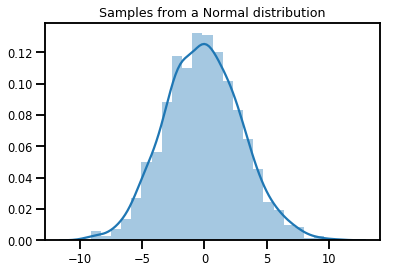

In [0]:
# Plot 1000 samples from the normal distribution
samples = dist.sample(1000)
sns.histplot(samples,bins=20,binrange=[-10,10],stat='probability')
plt.title("Samples from a Normal distribution")
plt.show()

In [0]:
# Compute the log_prob of a point in the event space of `dist`
np.exp(dist.log_prob(0.))

<tf.Tensor: id=34, shape=(), dtype=float32, numpy=-2.017551>

In [0]:
# Compute the log_prob of a few points
print(np.exp(dist.log_prob([-1., 0., 1.])))

# Evaluate the cdf at 1, returning a scalar.
print(dist.cdf(1.))

tf.Tensor([-2.0731065 -2.017551  -2.0731065], shape=(3,), dtype=float32)
tf.Tensor(0.63055867, shape=(), dtype=float32)


### Distributions and Shapes

Like Numpy `ndarrays`, TensorFlow `Tensors` have *shapes*.

TensorFlow Probability `Distributions` have *shape semantics* 

  * **Batch shape** denotes a *collection* of `Distribution`s with distinct parameters
  * **Event shape** denotes the shape of *samples* from the `Distribution`.


In [0]:
# Create a batch of 3 normals, and plot 1000 samples from each
normals = tfd.Normal([-2.5, 0., 2.5], 1.)  # The scale parameter broadcasts!
print("Batch shape:", normals.batch_shape)
print("Event shape:", normals.event_shape)

Batch shape: (3,)
Event shape: ()


In [0]:
# Samples' shapes go on the left!
samples = normals.sample(1000)
print("Shape of samples:", samples.shape)

Shape of samples: (1000, 3)


In [0]:
# A batch of normals gives a batch of log_probs.
print(np.exp(normals.log_prob([-2.5, 0., 2.5])))

tf.Tensor([-0.9189385 -0.9189385 -0.9189385], shape=(3,), dtype=float32)


In [0]:
# The computation broadcasts, so a batch of normals applied to a scalar
# also gives a batch of log_probs.
print(np.exp(normals.log_prob(0.)))

tf.Tensor([-4.0439386 -0.9189385 -4.0439386], shape=(3,), dtype=float32)


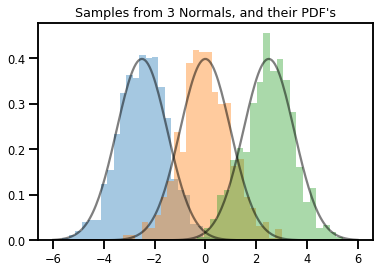

In [0]:
# Summarizing visually
xs = np.linspace(-6, 6, 200)[..., np.newaxis]
for i in range(3):
  sns.histplot(samples[:, i], kde=False,color=['green','red','blue'][i],stat='density')
plt.plot(np.tile(xs, 3), normals.prob(xs), c='k', alpha=.5)
plt.title("Samples from 3 Normals, and their PDF's")
plt.show()

In [0]:
mvn = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag = [1., 1.])
print("Batch shape:", mvn.batch_shape)
print("Event shape:", mvn.event_shape)

Batch shape: ()
Event shape: (2,)


In [0]:
samples = mvn.sample(1000)
print("Samples shape:", samples.shape)

Samples shape: (1000, 2)


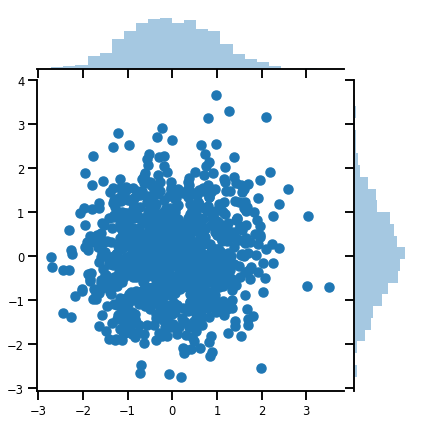

In [0]:
g = sns.jointplot(samples[:, 0], samples[:, 1], kind='scatter')
plt.show()

### Gaussian Processes

In [0]:
#create generic kernel
kernel = tfp.positive_semidefinite_kernels.ExponentiatedQuadratic()
xs = np.linspace(-5., 5., 200).reshape([-1, 1])
gp = tfd.GaussianProcess(kernel, index_points=xs)
print("Batch shape:", gp.batch_shape)
print("Event shape:", gp.event_shape)

Batch shape: ()
Event shape: (200,)


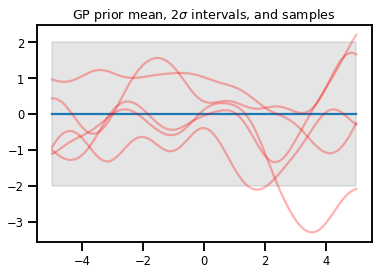

In [0]:
#Plot samples from the Gaussian Process with the mean and 2-sigma intervals

upper, lower = gp.mean() + [2 * gp.stddev(), -2 * gp.stddev()]
plt.plot(xs, gp.mean())
plt.fill_between(xs[..., 0], upper, lower, color='k', alpha=.1)
for _ in range(5):
  plt.plot(xs, gp.sample(), c='r', alpha=.3)
plt.title("GP prior mean, $2\sigma$ intervals, and samples")
plt.show()


### GP Regression

In [0]:
# Suppose we have some observed data
obs_x = [[-3.], [0.], [2.]]  # Shape 3x1 (3 1-D vectors)
obs_y = [3., -2., 2.]        # Shape 3   (3 scalars)

gprm = tfd.GaussianProcessRegressionModel(kernel, xs, obs_x, obs_y)

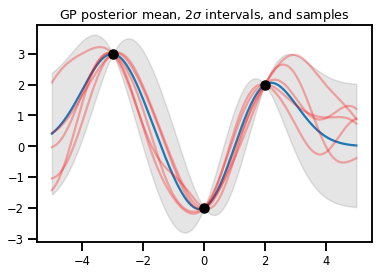

In [0]:
upper, lower = gprm.mean() + [2 * gprm.stddev(), -2 * gprm.stddev()]
plt.plot(xs, gprm.mean())
plt.fill_between(xs[..., 0], upper, lower, color='k', alpha=.1)
for _ in range(5):
  plt.plot(xs, gprm.sample(), c='r', alpha=.3)
plt.scatter(obs_x, obs_y, c='k', zorder=3)
plt.title("GP posterior mean, $2\sigma$ intervals, and samples")
plt.show()